# CNN CLASSIFICATION 

### Step 1: Import required packages

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import feature # This pacakge is used for LBP feature extraction
from sklearn.utils import shuffle
from sklearn import metrics 
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
%matplotlib inline
import cv2
import seaborn as sns # This pacakge is used for better visualization of data (e.g confusion matrix)
import tensorflow as tf
import os
import zipfile
%load_ext tensorboard
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint
from keras.utils.vis_utils import plot_model                   

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [16]:
root_dir = '/kaggle/input/state-farm-distracted-driver-detection/'
working_dir = '/kaggle/working'
model_dir = os.path.join(working_dir,"model")
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
checkpoint_dir = os.path.join(working_dir,"checkpoint")
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

In [17]:
%cd /kaggle/input/state-farm-distracted-driver-detection/imgs/

/kaggle/input/state-farm-distracted-driver-detection/imgs


### Step 2. Dataset preparation

In [19]:
base_dir = '/kaggle/input/state-farm-distracted-driver-detection/imgs'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')
if not os.path.exists(test_dir):
    print("Testing data does not exists")
if not os.path.exists(train_dir):
    print("Training data does not exists")

In [21]:
img_path = os.path.join(train_dir, "c0/img_34.jpg")
print(img_path)
# Read the image
image = cv2.imread(img_path)
print(image.shape)

/kaggle/input/state-farm-distracted-driver-detection/imgs/train/c0/img_34.jpg
(480, 640, 3)


### Getting info from csv file

In [22]:
data_train = pd.read_csv(os.path.join(root_dir, "driver_imgs_list.csv"))
data_train.info()
data_train['classname'].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22424 entries, 0 to 22423
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   subject    22424 non-null  object
 1   classname  22424 non-null  object
 2   img        22424 non-null  object
dtypes: object(3)
memory usage: 525.7+ KB


c0    2489
c3    2346
c4    2326
c6    2325
c2    2317
c5    2312
c1    2267
c9    2129
c7    2002
c8    1911
Name: classname, dtype: int64

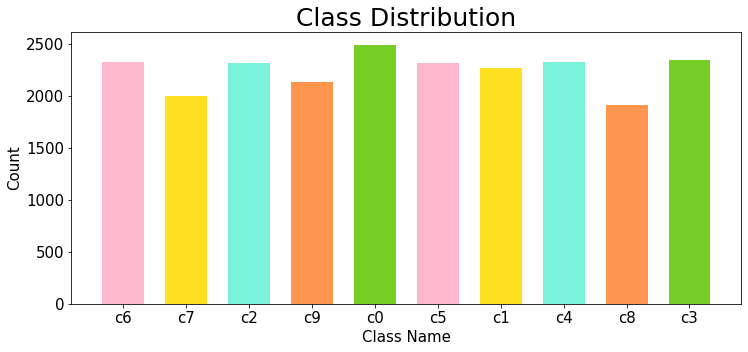

In [23]:
nf = data_train['classname'].value_counts(sort=False)
labels = data_train['classname'].value_counts(sort=False).index.tolist()
y = np.array(nf)
width = 1/1.5
N = len(y)
x = range(N)

fig = plt.figure(figsize=(12,5))
#ay = fig.add_subplot(211)

plt.xticks(x, labels, size=15)
plt.yticks(size=15)
plt.title('Class Distribution',size=25)
plt.xlabel('Class Name',size=15)
plt.ylabel('Count',size=15)

plt.bar(x, y, width, color= ('xkcd:baby pink', 'xkcd:sun yellow', 'xkcd:tiffany blue', 'xkcd:pastel orange', 'xkcd:apple green'))

plt.show()

### Step 3:  Design the CNN Architecture
Input: $150 X 150 X 3$ image

No. of filters, filter size:
- Conv1 : 64, 3x3
- Conv2 : 128, 3x3
- Conv3 : 256, 3x3
- Conv4 : 512, 3x3

Activation function in CONV layer: Relu

Pool: MaxPooling, 2x2
Dropout: 0.5

Activation function in Output layer : softmax, 10 classes

In [24]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(512, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5), #Adding Dropout
    tf.keras.layers.Dense(10, activation='softmax')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 148, 148, 64)      1792      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 74, 74, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 72, 72, 128)       73856     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 36, 36, 128)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 34, 34, 256)       295168    
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 17, 17, 256)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 15, 15, 512)      

In [27]:
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=1e-4),
              metrics=['acc'])

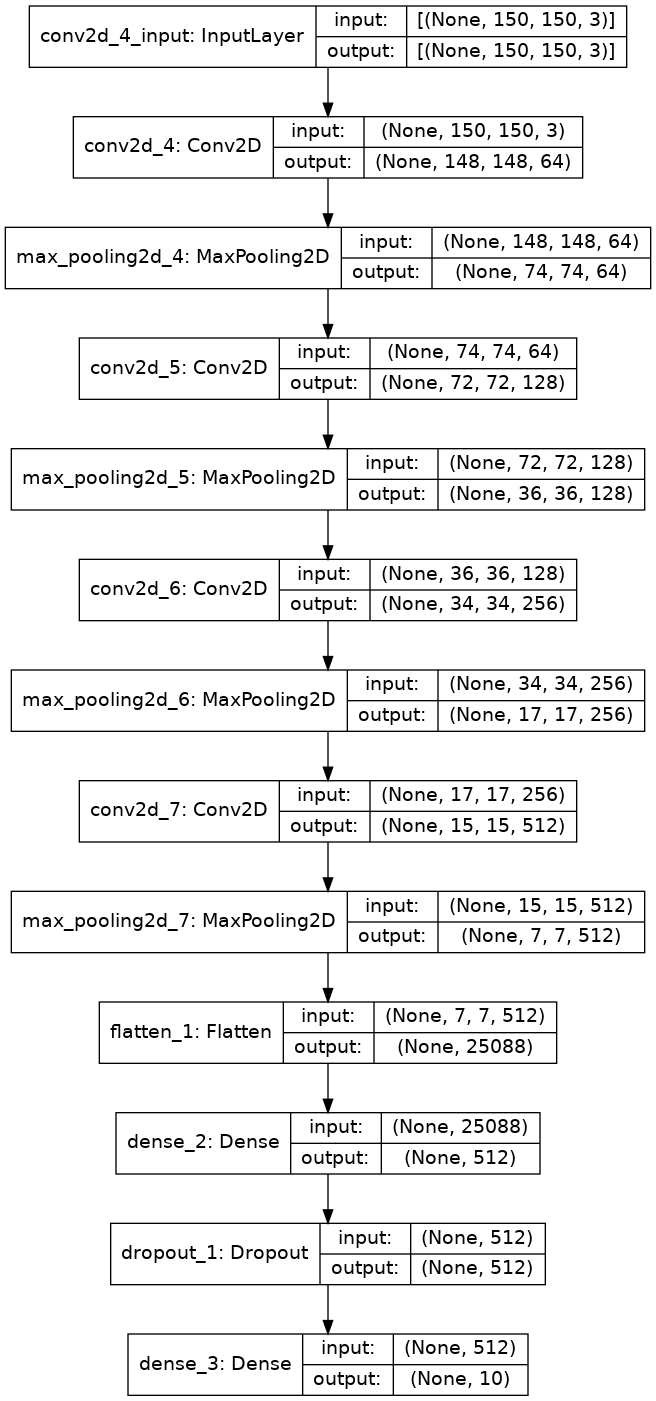

In [28]:
plot_model(model,to_file=os.path.join(model_dir,"CNNmodel_distracted_driver.png"),show_shapes=True,show_layer_names=True)

### Step 4:  Training CNN with ImageDataGenerator

In [29]:
# Updated to do image augmentation
train_datagen = ImageDataGenerator(
      rescale=1./255, validation_split=0.2)

test_datagen = ImageDataGenerator(
      rescale=1./255)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_dir, # This is the source directory for training images
        subset='training',
        target_size=(150, 150),  # All images will be resized to 150x150
        batch_size=20,
        # Since we use categorical_crossentropy loss, we need categorical labels
        class_mode='categorical')

# Flow validation images in batches of 20 using test_datagen generator
validation_generator = train_datagen.flow_from_directory(
        train_dir,
        subset='validation',
        target_size=(150, 150),
        batch_size=20,
        class_mode='categorical')

Found 17943 images belonging to 10 classes.
Found 4481 images belonging to 10 classes.


### Saving the snapshot of model as checkpoint

In [30]:
#checkpoint = ModelCheckpoint('weights.{epoch:02d}-{val_loss:.2f}.hdf5', monitor='val_loss', save_best_only=True, verbose=1, period=3)
filepath = os.path.join(checkpoint_dir, 'weights.{epoch:02d}-{val_loss:.2f}.hdf5')
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1)


### Training the model

In [31]:
history = model.fit_generator(
      train_generator,
      epochs=5,
      validation_data=validation_generator,
      callbacks = [checkpoint],
      verbose=2)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
898/898 - 107s - loss: 0.9458 - acc: 0.6726 - val_loss: 0.1401 - val_acc: 0.9650
Epoch 2/5
898/898 - 106s - loss: 0.1550 - acc: 0.9564 - val_loss: 0.0696 - val_acc: 0.9808
Epoch 3/5
898/898 - 106s - loss: 0.0752 - acc: 0.9786 - val_loss: 0.0418 - val_acc: 0.9877
Epoch 4/5
898/898 - 105s - loss: 0.0528 - acc: 0.9851 - val_loss: 0.0361 - val_acc: 0.9888
Epoch 5/5
898/898 - 105s - loss: 0.0351 - acc: 0.9896 - val_loss: 0.0282 - val_acc: 0.9926


In [39]:
%cd {working_dir}

/kaggle/working


In [40]:
model.save("customCNN.h5")

### Step 5:  Visualization of results

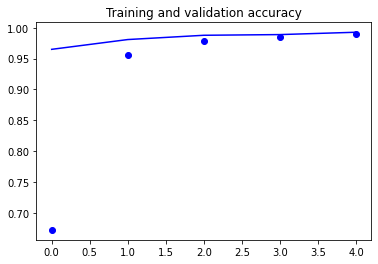

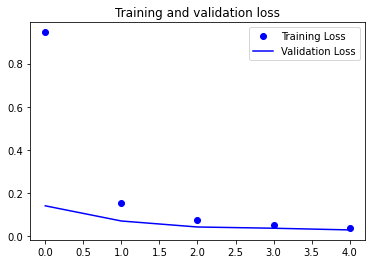

In [41]:
import matplotlib.pyplot as pltfp
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Step 6: Applying model on test dataset

In [42]:
import glob
from PIL import Image 
def load_data(fpath):    
    # Resize images to 150x150 for CNN compatibility
    img = Image.open(fpath).resize((150,150)) 
    img = np.asarray(img, dtype='float32') / 255.
    return img

TEST_IMAGE_PATHS = glob.glob(os.path.join(test_dir, "*.*"))
images = []
for file_path in TEST_IMAGE_PATHS[:1000]:
    images.append(load_data(file_path))
    
images = np.asarray(images)
images.shape

(1000, 150, 150, 3)

In [43]:
# Evaluate on 1000 images
import time
start = time.time()
result = model.predict(images)
end = time.time()
print("Processed time = ", end-start)

Processed time =  0.7507312297821045
